# lesson 1 
## common Pattern

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

## Trend and Seasonality

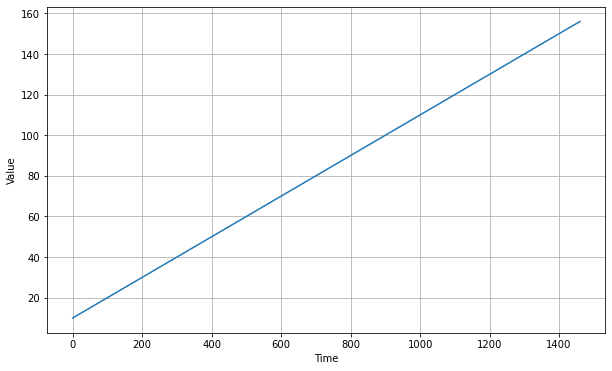

In [3]:
def trend(time, slope=0):
    return slope * time
# Let's create a time series that just trends upward:
time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
time

array([   0,    1,    2, ..., 1458, 1459, 1460])

In [5]:
series

array([ 10. ,  10.1,  10.2, ..., 155.8, 155.9, 156. ])

In [6]:
# Now let's generate a time series with a seasonal pattern:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

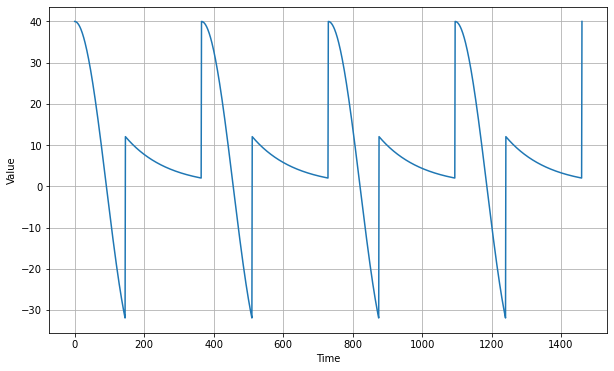

In [7]:
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

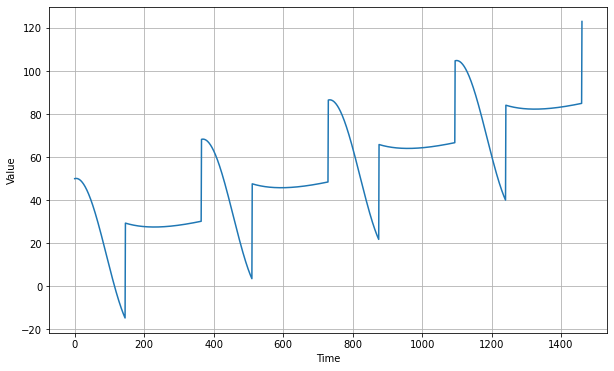

In [8]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Noise
In practice few real-life time series have such a smooth signal. They usually have some noise, and the signal-to-noise ratio can sometimes be very low. Let's generate some white noise:

In [9]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

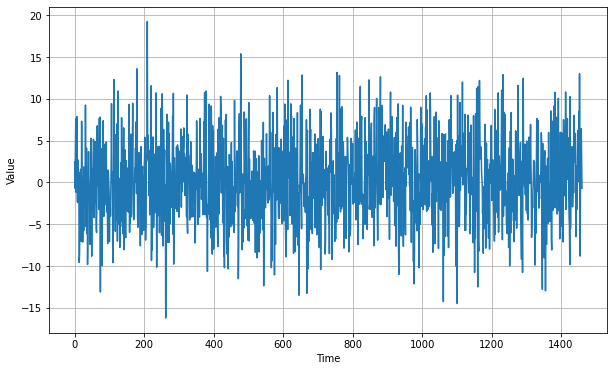

In [10]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

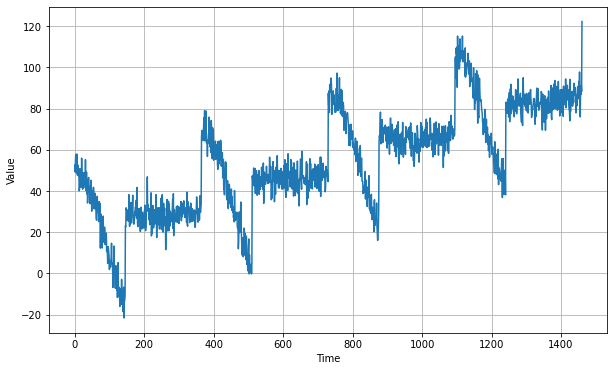

In [11]:
# Now let's add this white noise to the time series:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# Naive_Forecasting
## Trend and Seasonality

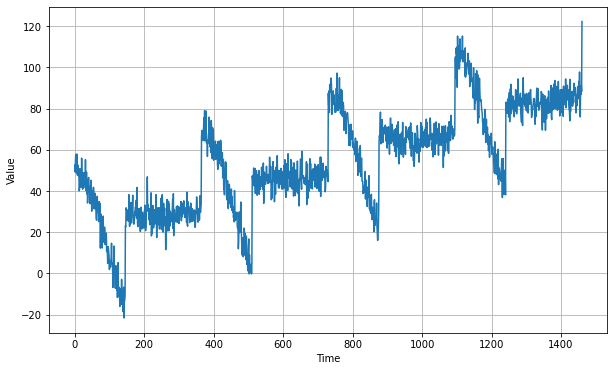

In [12]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [13]:
#All right, this looks realistic enough for now. Let's try to forecast it. We will split it into two periods:
#the training period and the validation period 
#(in many cases, you would also want to have a test period). The split will be at time step 1000.
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [14]:
# Naive Forecast
naive_forecast = series[split_time - 1:-1]

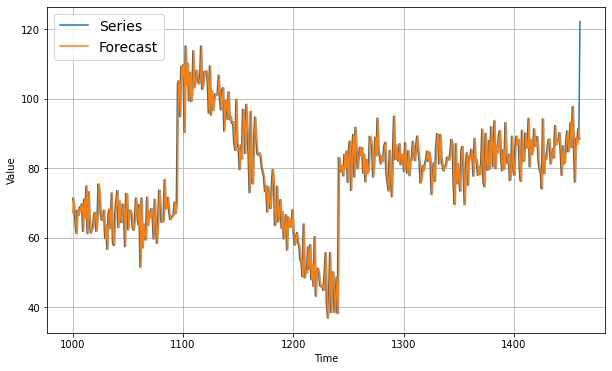

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, naive_forecast, label="Forecast")

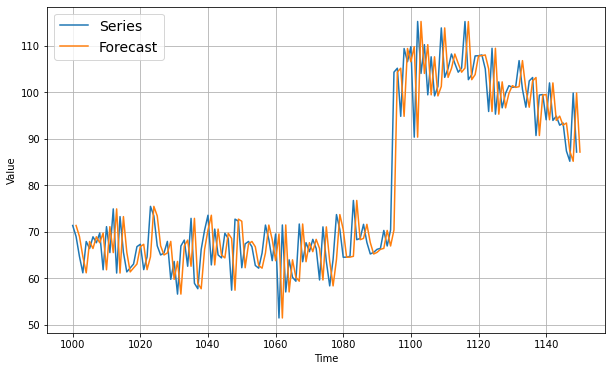

In [16]:
# Let's zoom in on the start of the validation period:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

You can see that the naive forecast lags 1 step behind the time series.

In [17]:
# Now let's compute the mean absolute error between the forecasts and the predictions in the validation period:
errors = naive_forecast - x_valid
abs_errors = np.abs(errors)
mae = abs_errors.mean()
mae

5.9379085153216735

# Moving Average

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [22]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)


In [24]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     This implementation is *much* faster than the previous one"""
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size

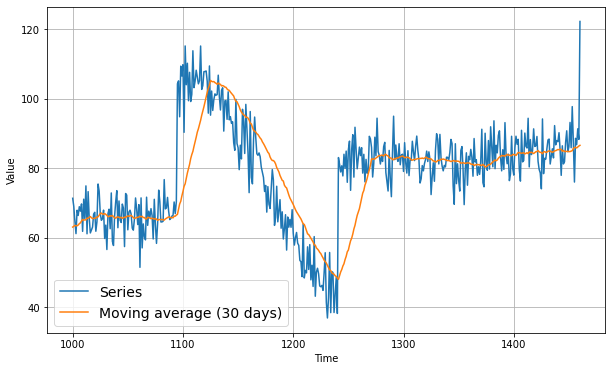

In [25]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

In [26]:
keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

7.142418570620783

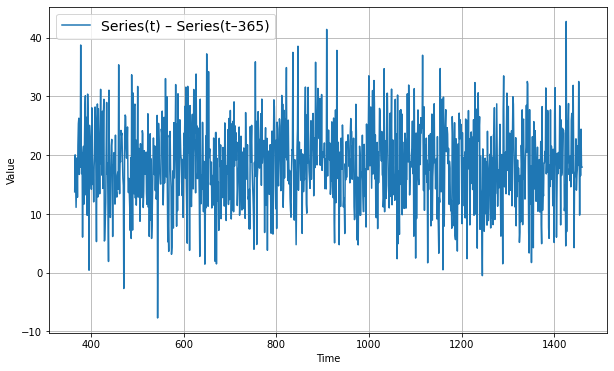

In [27]:
# differencing
#That's worse than naive forecast! The moving average does not anticipate trend or seasonality, 
#so let's try to remove them by using differencing. Since the seasonality period is 365 days, 
#we will subtract the value at time t – 365 from the value at time t.
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label="Series(t) – Series(t–365)")
plt.show()

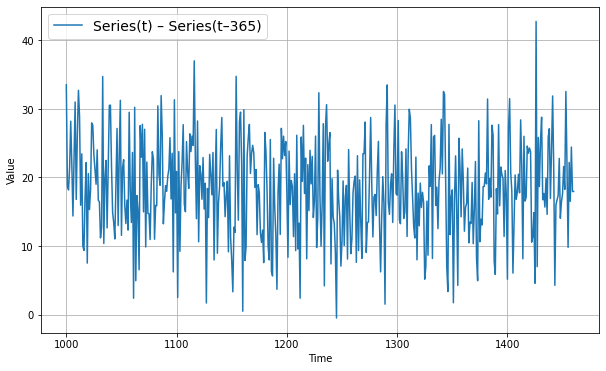

In [29]:
# Focusing on the validation period:
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plt.show()

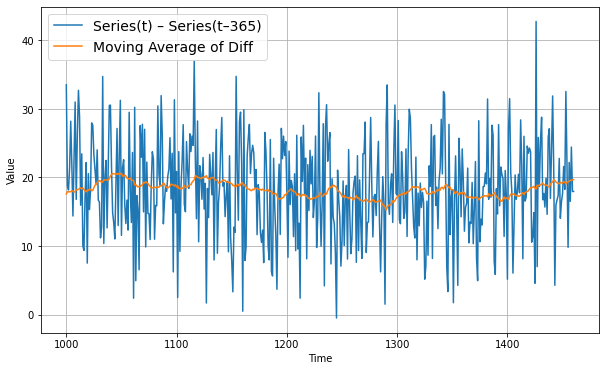

In [30]:
# Great, the trend and seasonality seem to be gone, so now we can use the moving average:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plot_series(time_valid, diff_moving_avg, label="Moving Average of Diff")
plt.show()

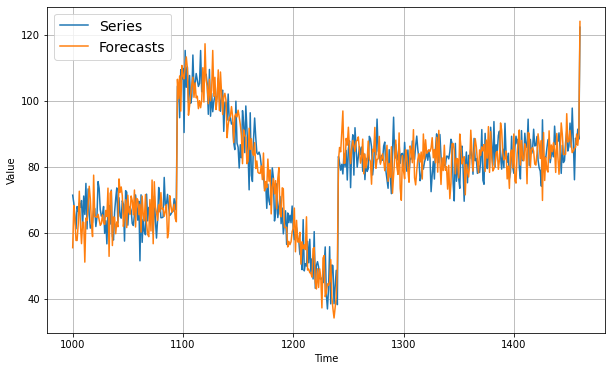

In [32]:
#Now let's bring back the trend and seasonality by adding the past values from t – 365:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_past, label="Forecasts")
plt.show()

In [33]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()

5.8393105629958955

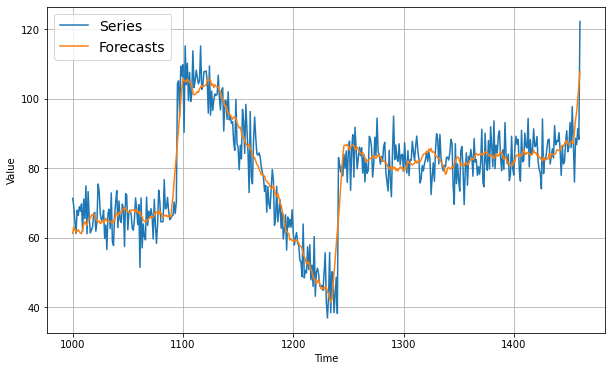

In [34]:
#Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values,
# which were noisy. Let's use a moving averaging on past values to remove some of the noise:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()

In [35]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()

4.566859958970772

# Time Windows 

First, we will train a model to forecast the next step given the previous 20 steps, therefore, we need to create a dataset of 20-step windows for training.

In [36]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
    print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [37]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [38]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [39]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [40]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x, y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [42]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x, y in dataset:
    print(x.numpy(), y.numpy())

[1 2 3 4] [5]
[2 3 4 5] [6]
[5 6 7 8] [9]
[3 4 5 6] [7]
[0 1 2 3] [4]
[4 5 6 7] [8]


In [43]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x, y in dataset:
    print("x =", x.numpy())
    print("y =", y.numpy())

x = [[1 2 3 4]
 [3 4 5 6]]
y = [[5]
 [7]]
x = [[5 6 7 8]
 [4 5 6 7]]
y = [[9]
 [8]]
x = [[0 1 2 3]
 [2 3 4 5]]
y = [[4]
 [6]]


In [44]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Forecasting with machine learning

In [47]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear Model

In [48]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

C:\Users\mjd\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
31/31 [==============================] - 2s 24ms/step - loss: 45.7126 - mae: 46.2094 - val_loss: 22.3332 - val_mae: 22.8332
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 7.7874 - mae: 8.2710 - val_loss: 6.4477 - val_mae: 6.9338
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 5.2543 - mae: 5.6980 - val_loss: 5.1462 - val_mae: 5.6357
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 4.8856 - mae: 5.3312 - val_loss: 4.6919 - val_mae: 5.1789
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 4.6177 - mae: 5.0675 - val_loss: 4.1469 - val_mae: 4.6450
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 4.3731 - mae: 4.8335 - val_loss: 3.9450 - val_mae: 4.4416
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 4.1968 - mae: 4.6496 - val_loss: 3.9350 - val_mae: 4.4015
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 4.014

31/31 [==============================] - 0s 5ms/step - loss: 1.8045 - mae: 2.1425 - val_loss: 1.8512 - val_mae: 2.2407
Epoch 64/100
31/31 [==============================] - 0s 6ms/step - loss: 1.7941 - mae: 2.1315 - val_loss: 1.8932 - val_mae: 2.2928
Epoch 65/100
31/31 [==============================] - 0s 5ms/step - loss: 1.7778 - mae: 2.1145 - val_loss: 1.7439 - val_mae: 2.1288
Epoch 66/100
31/31 [==============================] - 0s 5ms/step - loss: 1.7563 - mae: 2.0999 - val_loss: 1.7551 - val_mae: 2.1446
Epoch 67/100
31/31 [==============================] - 0s 4ms/step - loss: 1.7435 - mae: 2.0876 - val_loss: 1.7061 - val_mae: 2.0974
Epoch 68/100
31/31 [==============================] - 0s 5ms/step - loss: 1.7380 - mae: 2.0846 - val_loss: 1.6680 - val_mae: 2.0562
Epoch 69/100
31/31 [==============================] - 0s 5ms/step - loss: 1.7435 - mae: 2.0773 - val_loss: 1.6538 - val_mae: 2.0343
Epoch 70/100
31/31 [==============================] - 0s 5ms/step - loss: 1.7499 - mae: 2

In [49]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 67.4611 - mae: 67.9607 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 52.1621 - mae: 52.6617 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 34.4081 - mae: 34.9074 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 16.6554 - mae: 17.1544 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 4.8479 - mae: 5.3315 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 3.8899 - mae: 4.2951 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 3.7702 - mae: 4.1827 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 3.6624 - mae: 4.0682 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 3.5674 - mae: 4.0002 - lr: 1.84

31/31 [==============================] - 0s 2ms/step - loss: 5.4612 - mae: 5.9306 - lr: 2.7123e-04
Epoch 75/100
31/31 [==============================] - 0s 2ms/step - loss: 30.6194 - mae: 31.1182 - lr: 2.9286e-04
Epoch 76/100
31/31 [==============================] - 0s 1ms/step - loss: 18.5101 - mae: 19.0064 - lr: 3.1623e-04
Epoch 77/100
31/31 [==============================] - 0s 2ms/step - loss: 16.6230 - mae: 17.1194 - lr: 3.4145e-04
Epoch 78/100
31/31 [==============================] - 0s 2ms/step - loss: 11.9790 - mae: 12.4662 - lr: 3.6869e-04
Epoch 79/100
31/31 [==============================] - 0s 3ms/step - loss: 16.2081 - mae: 16.7026 - lr: 3.9811e-04
Epoch 80/100
31/31 [==============================] - 0s 3ms/step - loss: 20.3173 - mae: 20.8071 - lr: 4.2987e-04
Epoch 81/100
31/31 [==============================] - 0s 3ms/step - loss: 17.6295 - mae: 18.1247 - lr: 4.6416e-04
Epoch 82/100
31/31 [==============================] - 0s 3ms/step - loss: 26.3630 - mae: 26.8553 - lr: 

(1e-06, 0.001, 0.0, 20.0)

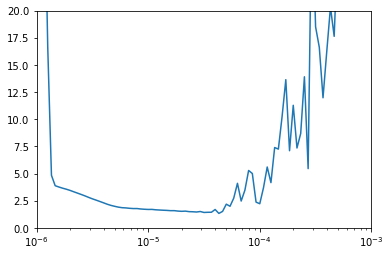

In [50]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [51]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 7ms/step - loss: 45.7126 - mae: 46.2094 - val_loss: 22.3332 - val_mae: 22.8332
Epoch 2/500
31/31 [==============================] - 0s 4ms/step - loss: 7.7874 - mae: 8.2710 - val_loss: 6.4477 - val_mae: 6.9338
Epoch 3/500
31/31 [==============================] - 0s 4ms/step - loss: 5.2543 - mae: 5.6980 - val_loss: 5.1462 - val_mae: 5.6357
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 4.8856 - mae: 5.3312 - val_loss: 4.6919 - val_mae: 5.1789
Epoch 5/500
31/31 [==============================] - 0s 6ms/step - loss: 4.6177 - mae: 5.0675 - val_loss: 4.1469 - val_mae: 4.6450
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 4.3731 - mae: 4.8335 - val_loss: 3.9450 - val_mae: 4.4416
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 4.1968 - mae: 4.6496 - val_loss: 3.9350 - val_mae: 4.4015
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 4.0144

31/31 [==============================] - 0s 4ms/step - loss: 1.8045 - mae: 2.1425 - val_loss: 1.8512 - val_mae: 2.2407
Epoch 64/500
31/31 [==============================] - 0s 5ms/step - loss: 1.7941 - mae: 2.1315 - val_loss: 1.8932 - val_mae: 2.2928
Epoch 65/500
31/31 [==============================] - 0s 5ms/step - loss: 1.7778 - mae: 2.1145 - val_loss: 1.7439 - val_mae: 2.1288
Epoch 66/500
31/31 [==============================] - 0s 4ms/step - loss: 1.7563 - mae: 2.0999 - val_loss: 1.7551 - val_mae: 2.1446
Epoch 67/500
31/31 [==============================] - 0s 5ms/step - loss: 1.7435 - mae: 2.0876 - val_loss: 1.7061 - val_mae: 2.0974
Epoch 68/500
31/31 [==============================] - 0s 5ms/step - loss: 1.7380 - mae: 2.0846 - val_loss: 1.6680 - val_mae: 2.0562
Epoch 69/500
31/31 [==============================] - 0s 5ms/step - loss: 1.7435 - mae: 2.0773 - val_loss: 1.6538 - val_mae: 2.0343
Epoch 70/500
31/31 [==============================] - 0s 5ms/step - loss: 1.7499 - mae: 2

Epoch 125/500
31/31 [==============================] - 0s 4ms/step - loss: 1.3215 - mae: 1.6008 - val_loss: 1.2621 - val_mae: 1.5696
Epoch 126/500
31/31 [==============================] - 0s 4ms/step - loss: 1.3135 - mae: 1.5868 - val_loss: 1.2759 - val_mae: 1.5895
Epoch 127/500
31/31 [==============================] - 0s 5ms/step - loss: 1.3024 - mae: 1.5732 - val_loss: 1.2451 - val_mae: 1.4294
Epoch 128/500
31/31 [==============================] - 0s 4ms/step - loss: 1.2991 - mae: 1.5662 - val_loss: 1.2217 - val_mae: 1.4906
Epoch 129/500
31/31 [==============================] - 0s 4ms/step - loss: 1.2998 - mae: 1.5736 - val_loss: 1.2247 - val_mae: 1.4233
Epoch 130/500
31/31 [==============================] - 0s 5ms/step - loss: 1.2858 - mae: 1.5484 - val_loss: 1.2147 - val_mae: 1.4803
Epoch 131/500
31/31 [==============================] - 0s 5ms/step - loss: 1.2801 - mae: 1.5480 - val_loss: 1.4008 - val_mae: 1.8181
Epoch 132/500
31/31 [==============================] - 0s 5ms/step - 

31/31 [==============================] - 0s 5ms/step - loss: 1.0675 - mae: 1.2846 - val_loss: 1.0262 - val_mae: 1.2330
Epoch 187/500
31/31 [==============================] - 0s 5ms/step - loss: 1.0673 - mae: 1.2961 - val_loss: 1.0317 - val_mae: 1.2733
Epoch 188/500
31/31 [==============================] - 0s 4ms/step - loss: 1.0681 - mae: 1.2982 - val_loss: 1.0211 - val_mae: 1.2192
Epoch 189/500
31/31 [==============================] - 0s 5ms/step - loss: 1.0699 - mae: 1.2918 - val_loss: 1.1078 - val_mae: 1.4584
Epoch 190/500
31/31 [==============================] - 0s 5ms/step - loss: 1.0656 - mae: 1.3042 - val_loss: 1.0229 - val_mae: 1.1891
Epoch 191/500
31/31 [==============================] - 0s 6ms/step - loss: 1.0488 - mae: 1.2633 - val_loss: 1.0632 - val_mae: 1.3546
Epoch 192/500
31/31 [==============================] - 0s 5ms/step - loss: 1.0494 - mae: 1.2704 - val_loss: 1.0350 - val_mae: 1.2425
Epoch 193/500
31/31 [==============================] - 0s 4ms/step - loss: 1.0515 -

Epoch 248/500
31/31 [==============================] - 0s 5ms/step - loss: 0.9022 - mae: 1.1199 - val_loss: 0.9020 - val_mae: 1.0971
Epoch 249/500
31/31 [==============================] - 0s 4ms/step - loss: 0.9068 - mae: 1.1225 - val_loss: 0.9698 - val_mae: 1.3217
Epoch 250/500
31/31 [==============================] - 0s 8ms/step - loss: 0.8995 - mae: 1.1099 - val_loss: 0.8916 - val_mae: 1.1312
Epoch 251/500
31/31 [==============================] - 0s 4ms/step - loss: 0.8942 - mae: 1.1017 - val_loss: 0.8965 - val_mae: 1.1457
Epoch 252/500
31/31 [==============================] - 0s 4ms/step - loss: 0.8916 - mae: 1.1076 - val_loss: 0.9243 - val_mae: 1.2191
Epoch 253/500
31/31 [==============================] - 0s 5ms/step - loss: 0.8896 - mae: 1.1010 - val_loss: 0.8831 - val_mae: 1.1171
Epoch 254/500
31/31 [==============================] - 0s 5ms/step - loss: 0.8889 - mae: 1.0932 - val_loss: 0.9162 - val_mae: 1.2043
Epoch 255/500
31/31 [==============================] - 0s 4ms/step - 

In [52]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [53]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

In [54]:
lin_forecast.shape

(461,)

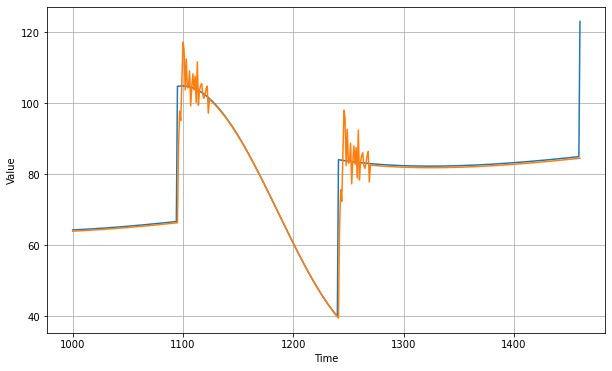

In [55]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [56]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

1.0838404

### Dense Model Forecasting

In [57]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

C:\Users\mjd\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
31/31 [==============================] - 1s 2ms/step - loss: 43.8913 - mae: 44.3908 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 41.3875 - mae: 41.8871 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 38.3163 - mae: 38.8157 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 34.8526 - mae: 35.3519 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 30.9588 - mae: 31.4583 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 26.5639 - mae: 27.0633 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 21.7475 - mae: 22.2470 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 16.5361 - mae: 17.0352 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 10.8406 - mae: 11.3344 

31/31 [==============================] - 0s 2ms/step - loss: 6.7572 - mae: 7.2411 - lr: 3.9811e-04
Epoch 74/100
31/31 [==============================] - 0s 2ms/step - loss: 7.5107 - mae: 7.9963 - lr: 4.4668e-04
Epoch 75/100
31/31 [==============================] - 0s 2ms/step - loss: 3.7495 - mae: 4.2240 - lr: 5.0119e-04
Epoch 76/100
31/31 [==============================] - 0s 2ms/step - loss: 6.7355 - mae: 7.2146 - lr: 5.6234e-04
Epoch 77/100
31/31 [==============================] - 0s 2ms/step - loss: 6.0677 - mae: 6.5234 - lr: 6.3096e-04
Epoch 78/100
31/31 [==============================] - 0s 2ms/step - loss: 6.7329 - mae: 7.2035 - lr: 7.0795e-04
Epoch 79/100
31/31 [==============================] - 0s 2ms/step - loss: 7.5957 - mae: 8.0734 - lr: 7.9433e-04
Epoch 80/100
31/31 [==============================] - 0s 2ms/step - loss: 6.0728 - mae: 6.5541 - lr: 8.9125e-04
Epoch 81/100
31/31 [==============================] - 0s 2ms/step - loss: 17.9052 - mae: 18.3955 - lr: 0.0010
Epoch 8

(1e-07, 0.005, 0.0, 30.0)

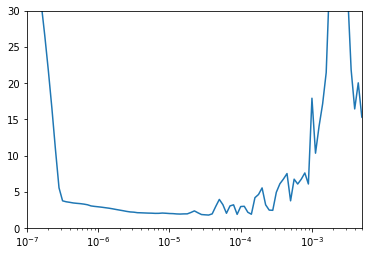

In [58]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [59]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 8ms/step - loss: 18.9917 - mae: 19.4873 - val_loss: 5.5124 - val_mae: 6.0118
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 6.1605 - mae: 6.6186 - val_loss: 4.7892 - val_mae: 5.2757
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 5.3739 - mae: 5.8065 - val_loss: 4.7302 - val_mae: 5.2227
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 4.8392 - mae: 5.2828 - val_loss: 4.0789 - val_mae: 4.5774
Epoch 5/500
31/31 [==============================] - 0s 5ms/step - loss: 4.4223 - mae: 4.8620 - val_loss: 3.3915 - val_mae: 3.8653
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 3.9941 - mae: 4.4449 - val_loss: 3.0931 - val_mae: 3.5883
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 3.6371 - mae: 4.0750 - val_loss: 2.7287 - val_mae: 3.0098
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 3.1838 -

31/31 [==============================] - 0s 6ms/step - loss: 1.2711 - mae: 1.4743 - val_loss: 0.9688 - val_mae: 1.1501
Epoch 64/500
31/31 [==============================] - 0s 5ms/step - loss: 1.2721 - mae: 1.4933 - val_loss: 1.0507 - val_mae: 1.3813
Epoch 65/500
31/31 [==============================] - 0s 5ms/step - loss: 1.2590 - mae: 1.4776 - val_loss: 0.9841 - val_mae: 1.2102
Epoch 66/500
31/31 [==============================] - 0s 4ms/step - loss: 1.2527 - mae: 1.4656 - val_loss: 0.9694 - val_mae: 1.2174
Epoch 67/500
31/31 [==============================] - 0s 4ms/step - loss: 1.2513 - mae: 1.4751 - val_loss: 1.1091 - val_mae: 1.4983
Epoch 68/500
31/31 [==============================] - 0s 4ms/step - loss: 1.2569 - mae: 1.5096 - val_loss: 1.0743 - val_mae: 1.4775
Epoch 69/500
31/31 [==============================] - 0s 4ms/step - loss: 1.2426 - mae: 1.4877 - val_loss: 1.0577 - val_mae: 1.4516
Epoch 70/500
31/31 [==============================] - 0s 4ms/step - loss: 1.2171 - mae: 1

Epoch 125/500
31/31 [==============================] - 0s 5ms/step - loss: 0.9830 - mae: 1.1578 - val_loss: 0.7754 - val_mae: 0.8990
Epoch 126/500
31/31 [==============================] - 0s 4ms/step - loss: 0.9889 - mae: 1.1802 - val_loss: 0.8444 - val_mae: 1.1777
Epoch 127/500
31/31 [==============================] - 0s 5ms/step - loss: 0.9813 - mae: 1.1650 - val_loss: 0.7765 - val_mae: 0.9297
Epoch 128/500
31/31 [==============================] - 0s 5ms/step - loss: 0.9748 - mae: 1.1452 - val_loss: 0.7914 - val_mae: 1.0110
Epoch 129/500
31/31 [==============================] - 0s 5ms/step - loss: 0.9731 - mae: 1.1463 - val_loss: 0.8946 - val_mae: 1.2912
Epoch 130/500
31/31 [==============================] - 0s 5ms/step - loss: 0.9948 - mae: 1.2220 - val_loss: 0.8267 - val_mae: 1.1510
Epoch 131/500
31/31 [==============================] - 0s 5ms/step - loss: 0.9720 - mae: 1.1517 - val_loss: 0.7661 - val_mae: 0.8870
Epoch 132/500
31/31 [==============================] - 0s 5ms/step - 

31/31 [==============================] - 0s 5ms/step - loss: 0.8535 - mae: 1.0251 - val_loss: 0.6897 - val_mae: 0.8544
Epoch 187/500
31/31 [==============================] - 0s 5ms/step - loss: 0.8465 - mae: 0.9913 - val_loss: 0.7471 - val_mae: 1.0832
Epoch 188/500
31/31 [==============================] - 0s 5ms/step - loss: 0.8700 - mae: 1.0956 - val_loss: 0.8361 - val_mae: 1.2372
Epoch 189/500
31/31 [==============================] - 0s 4ms/step - loss: 0.8849 - mae: 1.1397 - val_loss: 0.6881 - val_mae: 0.9057
Epoch 190/500
31/31 [==============================] - 0s 4ms/step - loss: 0.8557 - mae: 1.0455 - val_loss: 0.7460 - val_mae: 1.0885
Epoch 191/500
31/31 [==============================] - 0s 5ms/step - loss: 0.8455 - mae: 1.0314 - val_loss: 0.8402 - val_mae: 1.2502
Epoch 192/500
31/31 [==============================] - 0s 4ms/step - loss: 0.8696 - mae: 1.1035 - val_loss: 0.7412 - val_mae: 1.0729
Epoch 193/500
31/31 [==============================] - 0s 4ms/step - loss: 0.8402 -

Epoch 248/500
31/31 [==============================] - 0s 5ms/step - loss: 0.7645 - mae: 0.9570 - val_loss: 0.6191 - val_mae: 0.8356
Epoch 249/500
31/31 [==============================] - 0s 5ms/step - loss: 0.7545 - mae: 0.9035 - val_loss: 0.6392 - val_mae: 0.9218
Epoch 250/500
31/31 [==============================] - 0s 5ms/step - loss: 0.7530 - mae: 0.9034 - val_loss: 0.6296 - val_mae: 0.8839
Epoch 251/500
31/31 [==============================] - 0s 4ms/step - loss: 0.7569 - mae: 0.9193 - val_loss: 0.5979 - val_mae: 0.6768
Epoch 252/500
31/31 [==============================] - 0s 4ms/step - loss: 0.7489 - mae: 0.8839 - val_loss: 0.7195 - val_mae: 1.1032
Epoch 253/500
31/31 [==============================] - 0s 4ms/step - loss: 0.7476 - mae: 0.8947 - val_loss: 0.6463 - val_mae: 0.9413
Epoch 254/500
31/31 [==============================] - 0s 4ms/step - loss: 0.7595 - mae: 0.9582 - val_loss: 0.5929 - val_mae: 0.6960
Epoch 255/500
31/31 [==============================] - 0s 4ms/step - 

31/31 [==============================] - 0s 5ms/step - loss: 0.6927 - mae: 0.8807 - val_loss: 0.5662 - val_mae: 0.7788
Epoch 310/500
31/31 [==============================] - 0s 4ms/step - loss: 0.6881 - mae: 0.8556 - val_loss: 0.6509 - val_mae: 1.0098
Epoch 311/500
31/31 [==============================] - 0s 4ms/step - loss: 0.6851 - mae: 0.8440 - val_loss: 0.6511 - val_mae: 1.0101
Epoch 312/500
31/31 [==============================] - 0s 4ms/step - loss: 0.6868 - mae: 0.8611 - val_loss: 0.5524 - val_mae: 0.6850
Epoch 313/500
31/31 [==============================] - 0s 4ms/step - loss: 0.6791 - mae: 0.8305 - val_loss: 0.5847 - val_mae: 0.8472
Epoch 314/500
31/31 [==============================] - 0s 4ms/step - loss: 0.6825 - mae: 0.8539 - val_loss: 0.5452 - val_mae: 0.6369
Epoch 315/500
31/31 [==============================] - 0s 5ms/step - loss: 0.6891 - mae: 0.8749 - val_loss: 0.6023 - val_mae: 0.9103
Epoch 316/500
31/31 [==============================] - 0s 5ms/step - loss: 0.6793 -

In [60]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

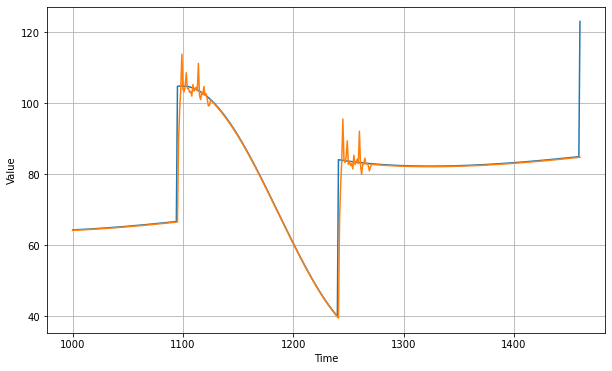

In [61]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [62]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

0.6971882

# RNN

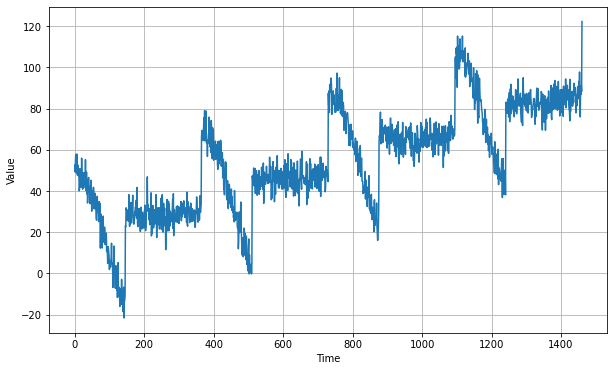

In [63]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [64]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [65]:
# Simple RNN Forecasting
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

C:\Users\mjd\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
8/8 [==============================] - 2s 35ms/step - loss: 50.2169 - mae: 50.7167 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 32ms/step - loss: 23.0009 - mae: 23.4932 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 0s 31ms/step - loss: 19.2073 - mae: 19.7003 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 0s 33ms/step - loss: 16.9702 - mae: 17.4605 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 0s 30ms/step - loss: 15.4093 - mae: 15.8988 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 0s 30ms/step - loss: 14.7507 - mae: 15.2367 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 29ms/step - loss: 14.3058 - mae: 14.7931 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 0s 31ms/step - loss: 14.0615 - mae: 14.5512 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 0s 29ms/step - loss: 13.7812 - mae: 14.2687 - lr: 2.5

8/8 [==============================] - 0s 28ms/step - loss: 751.4580 - mae: 751.9580 - lr: 3.9811e-04
Epoch 74/100
8/8 [==============================] - 0s 31ms/step - loss: 881.9223 - mae: 882.4223 - lr: 4.4668e-04
Epoch 75/100
8/8 [==============================] - 0s 33ms/step - loss: 940.5510 - mae: 941.0510 - lr: 5.0119e-04
Epoch 76/100
8/8 [==============================] - 0s 32ms/step - loss: 1061.6411 - mae: 1062.1411 - lr: 5.6234e-04
Epoch 77/100
8/8 [==============================] - 0s 28ms/step - loss: 1680.7196 - mae: 1681.2195 - lr: 6.3096e-04
Epoch 78/100
8/8 [==============================] - 0s 28ms/step - loss: 2879.8149 - mae: 2880.3149 - lr: 7.0795e-04
Epoch 79/100
8/8 [==============================] - 0s 29ms/step - loss: 2962.4131 - mae: 2962.9131 - lr: 7.9433e-04
Epoch 80/100
8/8 [==============================] - 0s 31ms/step - loss: 3075.9041 - mae: 3076.4038 - lr: 8.9125e-04
Epoch 81/100
8/8 [==============================] - 0s 29ms/step - loss: 3197.9604 

(1e-07, 0.0001, 0.0, 30.0)

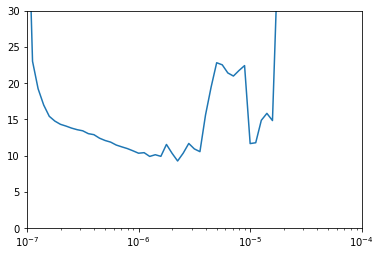

In [66]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [67]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
      7/Unknown - 2s 31ms/step - loss: 57.3394 - mae: 57.8379INFO:tensorflow:Assets written to: my_checkpoint\assets
8/8 [==============================] - 7s 777ms/step - loss: 54.8857 - mae: 55.3843 - val_loss: 53.7731 - val_mae: 54.2731
Epoch 2/500
8/8 [==============================] - 5s 770ms/step - loss: 35.4596 - mae: 35.9565 - val_loss: 17.5199 - val_mae: 18.0161
Epoch 3/500
8/8 [==============================] - 0s 47ms/step - loss: 22.5446 - mae: 23.0386 - val_loss: 18.8167 - val_mae: 19.3136
Epoch 4/500
8/8 [==============================] - 1s 57ms/step - loss: 16.2156 - mae: 16.7054 - val_loss: 20.0785 - val_mae: 20.5772
Epoch 5/500
8/8 [==============================] - 4s 504ms/step - loss: 13.7456 - mae: 14.2346 - val_loss: 6.8457 - val_mae: 7.3288
Epoch 6/500
8/8 [==============================] - 0s 44ms/step - loss: 11.3547 - mae: 11.8350 - val_loss: 7.2706 - val_mae: 7.7554
Epoch 7/500
8/8 [==============================] - 0s 59ms/step - loss: 10.7631 

8/8 [==============================] - 0s 48ms/step - loss: 6.2475 - mae: 6.7316 - val_loss: 9.4454 - val_mae: 9.9414
Epoch 54/500
8/8 [==============================] - 0s 51ms/step - loss: 6.6254 - mae: 7.1118 - val_loss: 5.1424 - val_mae: 5.6192
Epoch 55/500
8/8 [==============================] - 0s 52ms/step - loss: 6.7725 - mae: 7.2525 - val_loss: 5.7713 - val_mae: 6.2562
Epoch 56/500
8/8 [==============================] - 0s 49ms/step - loss: 6.9321 - mae: 7.4200 - val_loss: 5.7383 - val_mae: 6.2183
Epoch 57/500
8/8 [==============================] - 0s 48ms/step - loss: 5.8178 - mae: 6.2985 - val_loss: 5.1172 - val_mae: 5.5917
Epoch 58/500
8/8 [==============================] - 0s 48ms/step - loss: 6.0433 - mae: 6.5190 - val_loss: 7.4305 - val_mae: 7.9155
Epoch 59/500
8/8 [==============================] - 1s 60ms/step - loss: 5.7946 - mae: 6.2724 - val_loss: 6.6448 - val_mae: 7.1291
Epoch 60/500
8/8 [==============================] - 1s 54ms/step - loss: 5.6307 - mae: 6.1074 - 

Epoch 111/500
8/8 [==============================] - 0s 53ms/step - loss: 4.9848 - mae: 5.4589 - val_loss: 5.3269 - val_mae: 5.8102
Epoch 112/500
8/8 [==============================] - 1s 74ms/step - loss: 5.0177 - mae: 5.4948 - val_loss: 5.1846 - val_mae: 5.6698
Epoch 113/500
8/8 [==============================] - 0s 53ms/step - loss: 4.7052 - mae: 5.1779 - val_loss: 5.0071 - val_mae: 5.4804
Epoch 114/500
8/8 [==============================] - 0s 47ms/step - loss: 4.9924 - mae: 5.4697 - val_loss: 5.4819 - val_mae: 5.9590
Epoch 115/500
8/8 [==============================] - 1s 56ms/step - loss: 5.2149 - mae: 5.6951 - val_loss: 8.4176 - val_mae: 8.9079
Epoch 116/500
8/8 [==============================] - 0s 51ms/step - loss: 5.5694 - mae: 6.0533 - val_loss: 4.9969 - val_mae: 5.4694
Epoch 117/500
8/8 [==============================] - 0s 47ms/step - loss: 5.2112 - mae: 5.6912 - val_loss: 5.8994 - val_mae: 6.3906
Epoch 118/500
8/8 [==============================] - 0s 47ms/step - loss: 5.

In [68]:
model = keras.models.load_model("my_checkpoint")

In [69]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

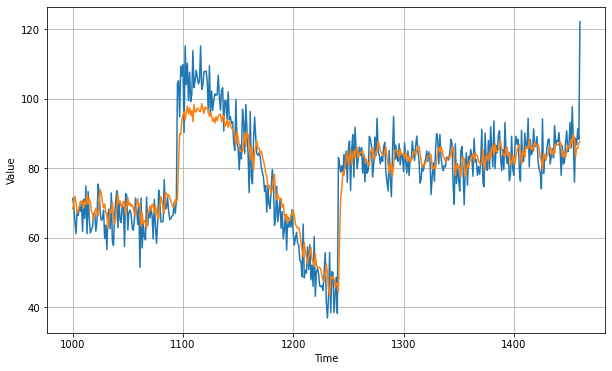

In [70]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [71]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.3282113

## Sequence-to-Sequence Forecasting

In [72]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [73]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]


In [74]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

C:\Users\mjd\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
8/8 [==============================] - 2s 40ms/step - loss: 52.3615 - mae: 52.8611 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 33ms/step - loss: 25.4713 - mae: 25.9671 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 0s 35ms/step - loss: 23.5029 - mae: 23.9971 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 0s 35ms/step - loss: 21.1367 - mae: 21.6294 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 0s 34ms/step - loss: 19.4762 - mae: 19.9674 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 0s 36ms/step - loss: 18.6742 - mae: 19.1647 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 0s 34ms/step - loss: 18.1698 - mae: 18.6587 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 0s 37ms/step - loss: 17.7679 - mae: 18.2568 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 0s 37ms/step - loss: 17.4389 - mae: 17.9280 - lr: 1.8

8/8 [==============================] - 0s 39ms/step - loss: 37.8544 - mae: 38.3538 - lr: 2.5119e-05
Epoch 74/100
8/8 [==============================] - 0s 38ms/step - loss: 38.8881 - mae: 39.3876 - lr: 2.7123e-05
Epoch 75/100
8/8 [==============================] - 0s 34ms/step - loss: 41.3393 - mae: 41.8387 - lr: 2.9286e-05
Epoch 76/100
8/8 [==============================] - 0s 36ms/step - loss: 41.1273 - mae: 41.6265 - lr: 3.1623e-05
Epoch 77/100
8/8 [==============================] - 0s 35ms/step - loss: 43.1464 - mae: 43.6457 - lr: 3.4145e-05
Epoch 78/100
8/8 [==============================] - 0s 36ms/step - loss: 45.1440 - mae: 45.6438 - lr: 3.6869e-05
Epoch 79/100
8/8 [==============================] - 0s 36ms/step - loss: 46.3466 - mae: 46.8462 - lr: 3.9811e-05
Epoch 80/100
8/8 [==============================] - 0s 37ms/step - loss: 46.1646 - mae: 46.6643 - lr: 4.2987e-05
Epoch 81/100
8/8 [==============================] - 0s 34ms/step - loss: 47.6009 - mae: 48.1004 - lr: 4.6416e

(1e-07, 0.0001, 0.0, 30.0)

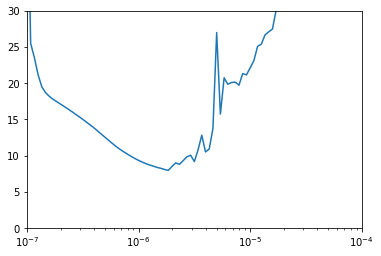

In [75]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [76]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 2s 100ms/step - loss: 54.1427 - mae: 54.6412 - val_loss: 17.9209 - val_mae: 18.4158
Epoch 2/500
8/8 [==============================] - 0s 50ms/step - loss: 34.1721 - mae: 34.6694 - val_loss: 20.5481 - val_mae: 21.0440
Epoch 3/500
8/8 [==============================] - 0s 52ms/step - loss: 27.5074 - mae: 28.0027 - val_loss: 37.8711 - val_mae: 38.3706
Epoch 4/500
8/8 [==============================] - 1s 57ms/step - loss: 21.0646 - mae: 21.5578 - val_loss: 25.2685 - val_mae: 25.7674
Epoch 5/500
8/8 [==============================] - 0s 53ms/step - loss: 17.1768 - mae: 17.6667 - val_loss: 15.3555 - val_mae: 15.8505
Epoch 6/500
8/8 [==============================] - 1s 54ms/step - loss: 15.0382 - mae: 15.5247 - val_loss: 9.4217 - val_mae: 9.9070
Epoch 7/500
8/8 [==============================] - 0s 54ms/step - loss: 13.9508 - mae: 14.4372 - val_loss: 9.1618 - val_mae: 9.6475
Epoch 8/500
8/8 [==============================] - 1s 55ms/step -

8/8 [==============================] - 1s 57ms/step - loss: 6.3027 - mae: 6.7813 - val_loss: 5.4634 - val_mae: 5.9396
Epoch 64/500
8/8 [==============================] - 0s 51ms/step - loss: 6.2800 - mae: 6.7595 - val_loss: 5.6596 - val_mae: 6.1384
Epoch 65/500
8/8 [==============================] - 0s 55ms/step - loss: 6.2597 - mae: 6.7382 - val_loss: 5.4920 - val_mae: 5.9685
Epoch 66/500
8/8 [==============================] - 0s 51ms/step - loss: 6.2370 - mae: 6.7161 - val_loss: 5.5227 - val_mae: 5.9986
Epoch 67/500
8/8 [==============================] - 1s 55ms/step - loss: 6.2181 - mae: 6.6968 - val_loss: 5.5079 - val_mae: 5.9838
Epoch 68/500
8/8 [==============================] - 1s 57ms/step - loss: 6.1976 - mae: 6.6767 - val_loss: 5.5154 - val_mae: 5.9910
Epoch 69/500
8/8 [==============================] - 0s 53ms/step - loss: 6.1796 - mae: 6.6588 - val_loss: 5.5413 - val_mae: 6.0176
Epoch 70/500
8/8 [==============================] - 0s 51ms/step - loss: 6.1641 - mae: 6.6427 - 

In [77]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

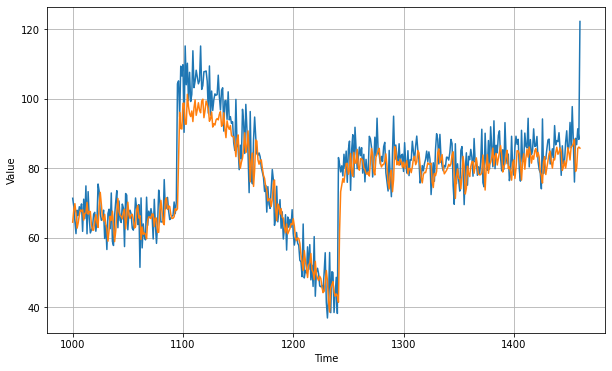

In [78]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [79]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.4588737

# Forecasting With Stateful RNNs

In [80]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [81]:
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
    print(X_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [82]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [83]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

C:\Users\mjd\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
33/33 [==============================] - 2s 9ms/step - loss: 105.9339 - mae: 106.4339 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 8ms/step - loss: 70.8571 - mae: 71.3570 - lr: 1.0798e-08
Epoch 3/100
33/33 [==============================] - 0s 8ms/step - loss: 39.8079 - mae: 40.3047 - lr: 1.1659e-08
Epoch 4/100
33/33 [==============================] - 0s 9ms/step - loss: 27.3450 - mae: 27.8404 - lr: 1.2589e-08
Epoch 5/100
33/33 [==============================] - 0s 8ms/step - loss: 24.4956 - mae: 24.9891 - lr: 1.3594e-08
Epoch 6/100
33/33 [==============================] - 0s 8ms/step - loss: 23.2601 - mae: 23.7517 - lr: 1.4678e-08
Epoch 7/100
33/33 [==============================] - 0s 8ms/step - loss: 22.0604 - mae: 22.5533 - lr: 1.5849e-08
Epoch 8/100
33/33 [==============================] - 0s 8ms/step - loss: 20.8543 - mae: 21.3463 - lr: 1.7113e-08
Epoch 9/100
33/33 [==============================] - 0s 8ms/step - loss: 19.8307 - mae: 20.324

33/33 [==============================] - 0s 8ms/step - loss: 15.8039 - mae: 16.2982 - lr: 2.5119e-06
Epoch 74/100
33/33 [==============================] - 0s 8ms/step - loss: 19.7907 - mae: 20.2859 - lr: 2.7123e-06
Epoch 75/100
33/33 [==============================] - 0s 8ms/step - loss: 20.9170 - mae: 21.4140 - lr: 2.9286e-06
Epoch 76/100
33/33 [==============================] - 0s 8ms/step - loss: 11.6638 - mae: 12.1561 - lr: 3.1623e-0608 - mae: 13.
Epoch 77/100
33/33 [==============================] - 0s 9ms/step - loss: 17.5050 - mae: 18.0019 - lr: 3.4145e-06
Epoch 78/100
33/33 [==============================] - 0s 8ms/step - loss: 13.2580 - mae: 13.7486 - lr: 3.6869e-06
Epoch 79/100
33/33 [==============================] - 0s 9ms/step - loss: 18.4841 - mae: 18.9800 - lr: 3.9811e-06
Epoch 80/100
33/33 [==============================] - 0s 8ms/step - loss: 19.5365 - mae: 20.0303 - lr: 4.2987e-06
Epoch 81/100
33/33 [==============================] - 0s 8ms/step - loss: 23.0151 - mae:

(1e-08, 0.0001, 0.0, 30.0)

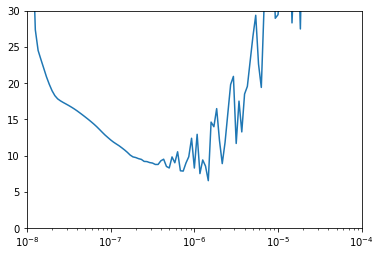

In [84]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [85]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 4s 56ms/step - loss: 60.2497 - mae: 60.7476 - val_loss: 25.0215 - val_mae: 25.5176
Epoch 2/500
33/33 [==============================] - 0s 15ms/step - loss: 21.4714 - mae: 21.9618 - val_loss: 10.9142 - val_mae: 11.4074
Epoch 3/500
33/33 [==============================] - 0s 10ms/step - loss: 18.7249 - mae: 19.2167 - val_loss: 12.0569 - val_mae: 12.5479
Epoch 4/500
33/33 [==============================] - 0s 15ms/step - loss: 17.5231 - mae: 18.0143 - val_loss: 10.4488 - val_mae: 10.9391
Epoch 5/500
33/33 [==============================] - 1s 16ms/step - loss: 16.6983 - mae: 17.1891 - val_loss: 9.9581 - val_mae: 10.4499
Epoch 6/500
33/33 [==============================] - 1s 16ms/step - loss: 15.9090 - mae: 16.3984 - val_loss: 9.1539 - val_mae: 9.6415
Epoch 7/500
33/33 [==============================] - 1s 16ms/step - loss: 15.2155 - mae: 15.7027 - val_loss: 8.3393 - val_mae: 8.8249
Epoch 8/500
33/33 [==============================] - 

33/33 [==============================] - 0s 10ms/step - loss: 7.5705 - mae: 8.0485 - val_loss: 7.2326 - val_mae: 7.7193
Epoch 63/500
33/33 [==============================] - 0s 11ms/step - loss: 7.5344 - mae: 8.0126 - val_loss: 7.2253 - val_mae: 7.7120
Epoch 64/500
33/33 [==============================] - 0s 10ms/step - loss: 7.5009 - mae: 7.9792 - val_loss: 7.2330 - val_mae: 7.7198
Epoch 65/500
33/33 [==============================] - 0s 11ms/step - loss: 7.4706 - mae: 7.9491 - val_loss: 7.2638 - val_mae: 7.7507
Epoch 66/500
33/33 [==============================] - 0s 12ms/step - loss: 7.4424 - mae: 7.9210 - val_loss: 7.3071 - val_mae: 7.7941
Epoch 67/500
33/33 [==============================] - 0s 12ms/step - loss: 7.4135 - mae: 7.8922 - val_loss: 7.3386 - val_mae: 7.8257
Epoch 68/500
33/33 [==============================] - 0s 11ms/step - loss: 7.3803 - mae: 7.8593 - val_loss: 7.3363 - val_mae: 7.8234
Epoch 69/500
33/33 [==============================] - 0s 10ms/step - loss: 7.3444 

In [86]:
model = keras.models.load_model("my_checkpoint.h5")

In [87]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

In [88]:
rnn_forecast.shape

(461,)

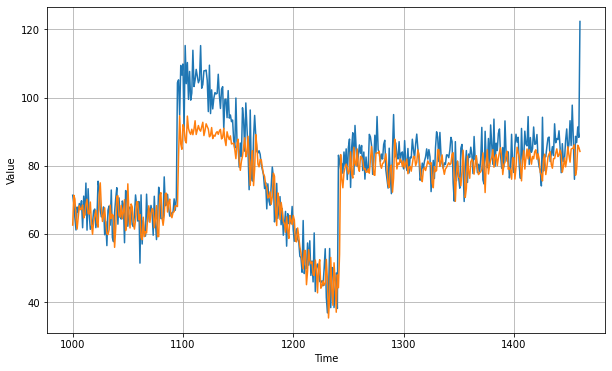

In [89]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [90]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

6.2778406

# LSTM RNN Forecasting

In [91]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

C:\Users\mjd\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
33/33 [==============================] - 4s 13ms/step - loss: 90.9191 - mae: 91.4191 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 12ms/step - loss: 83.8978 - mae: 84.3978 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 0s 12ms/step - loss: 75.4974 - mae: 75.9974 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 0s 14ms/step - loss: 66.0676 - mae: 66.5676 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 0s 14ms/step - loss: 55.5131 - mae: 56.0131 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 0s 13ms/step - loss: 43.7599 - mae: 44.2597 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 0s 14ms/step - loss: 30.7909 - mae: 31.2900 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 0s 13ms/step - loss: 17.1478 - mae: 17.6436 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 0s 14ms/step - loss: 10.0311 - mae:

Epoch 73/100
33/33 [==============================] - 0s 13ms/step - loss: 12.3219 - mae: 12.8113 - lr: 3.9811e-05
Epoch 74/100
33/33 [==============================] - 0s 14ms/step - loss: 12.1802 - mae: 12.6683 - lr: 4.4668e-05
Epoch 75/100
33/33 [==============================] - 0s 13ms/step - loss: 10.3306 - mae: 10.8243 - lr: 5.0119e-05
Epoch 76/100
33/33 [==============================] - 0s 12ms/step - loss: 11.5463 - mae: 12.0340 - lr: 5.6234e-05657 - mae: 12
Epoch 77/100
33/33 [==============================] - 0s 13ms/step - loss: 7.9967 - mae: 8.4842 - lr: 6.3096e-05
Epoch 78/100
33/33 [==============================] - 0s 13ms/step - loss: 16.9219 - mae: 17.4182 - lr: 7.0795e-05
Epoch 79/100
33/33 [==============================] - 0s 13ms/step - loss: 15.0063 - mae: 15.4993 - lr: 7.9433e-05
Epoch 80/100
33/33 [==============================] - 0s 13ms/step - loss: 10.8455 - mae: 11.3303 - lr: 8.9125e-05
Epoch 81/100
33/33 [==============================] - 0s 13ms/step - 

(1e-08, 0.0001, 0.0, 30.0)

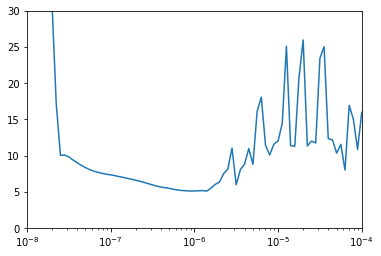

In [92]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [93]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 4s 50ms/step - loss: 30.0122 - mae: 30.5050 - val_loss: 13.0810 - val_mae: 13.5746
Epoch 2/500
33/33 [==============================] - 1s 27ms/step - loss: 15.3618 - mae: 15.8570 - val_loss: 10.0991 - val_mae: 10.5941
Epoch 3/500
33/33 [==============================] - 0s 15ms/step - loss: 10.9284 - mae: 11.4173 - val_loss: 11.2192 - val_mae: 11.7083
Epoch 4/500
33/33 [==============================] - 1s 15ms/step - loss: 9.8165 - mae: 10.3052 - val_loss: 12.2806 - val_mae: 12.7757
Epoch 5/500
33/33 [==============================] - 1s 23ms/step - loss: 7.8424 - mae: 8.3317 - val_loss: 9.6437 - val_mae: 10.1336
Epoch 6/500
33/33 [==============================] - 1s 17ms/step - loss: 7.1708 - mae: 7.6561 - val_loss: 10.6124 - val_mae: 11.1036
Epoch 7/500
33/33 [==============================] - 1s 15ms/step - loss: 5.9200 - mae: 6.4041 - val_loss: 10.1595 - val_mae: 10.6522
Epoch 8/500
33/33 [==============================] - 1s 

33/33 [==============================] - 1s 25ms/step - loss: 4.8800 - mae: 5.3581 - val_loss: 7.7570 - val_mae: 8.2442
Epoch 63/500
33/33 [==============================] - 1s 24ms/step - loss: 4.8741 - mae: 5.3520 - val_loss: 7.7333 - val_mae: 8.2205
Epoch 64/500
33/33 [==============================] - 1s 27ms/step - loss: 4.8722 - mae: 5.3498 - val_loss: 7.6966 - val_mae: 8.1836
Epoch 65/500
33/33 [==============================] - 1s 23ms/step - loss: 4.8715 - mae: 5.3490 - val_loss: 7.6494 - val_mae: 8.1360
Epoch 66/500
33/33 [==============================] - 1s 22ms/step - loss: 4.8703 - mae: 5.3477 - val_loss: 7.5974 - val_mae: 8.0836
Epoch 67/500
33/33 [==============================] - 1s 24ms/step - loss: 4.8670 - mae: 5.3447 - val_loss: 7.5479 - val_mae: 8.0336
Epoch 68/500
33/33 [==============================] - 1s 24ms/step - loss: 4.8605 - mae: 5.3386 - val_loss: 7.5021 - val_mae: 7.9872
Epoch 69/500
33/33 [==============================] - 1s 22ms/step - loss: 4.8501 

33/33 [==============================] - 1s 16ms/step - loss: 4.5730 - mae: 5.0498 - val_loss: 6.3979 - val_mae: 6.8793
Epoch 124/500
33/33 [==============================] - 1s 16ms/step - loss: 4.5806 - mae: 5.0581 - val_loss: 6.3476 - val_mae: 6.8284
Epoch 125/500
33/33 [==============================] - 1s 25ms/step - loss: 4.5904 - mae: 5.0685 - val_loss: 6.2877 - val_mae: 6.7682
Epoch 126/500
33/33 [==============================] - 1s 24ms/step - loss: 4.5976 - mae: 5.0764 - val_loss: 6.2280 - val_mae: 6.7075
Epoch 127/500
33/33 [==============================] - 1s 22ms/step - loss: 4.6012 - mae: 5.0806 - val_loss: 6.1625 - val_mae: 6.6409
Epoch 128/500
33/33 [==============================] - 1s 28ms/step - loss: 4.6009 - mae: 5.0804 - val_loss: 6.1093 - val_mae: 6.5874
Epoch 129/500
33/33 [==============================] - 1s 25ms/step - loss: 4.5965 - mae: 5.0762 - val_loss: 6.0682 - val_mae: 6.5464
Epoch 130/500
33/33 [==============================] - 1s 25ms/step - loss: 

33/33 [==============================] - 1s 27ms/step - loss: 4.4777 - mae: 4.9560 - val_loss: 5.8716 - val_mae: 6.3484
Epoch 185/500
33/33 [==============================] - 1s 23ms/step - loss: 4.4720 - mae: 4.9500 - val_loss: 5.8624 - val_mae: 6.3390
Epoch 186/500
33/33 [==============================] - 1s 24ms/step - loss: 4.4672 - mae: 4.9447 - val_loss: 5.8582 - val_mae: 6.3347
Epoch 187/500
33/33 [==============================] - 1s 24ms/step - loss: 4.4631 - mae: 4.9402 - val_loss: 5.8564 - val_mae: 6.3328
Epoch 188/500
33/33 [==============================] - 1s 22ms/step - loss: 4.4601 - mae: 4.9368 - val_loss: 5.8563 - val_mae: 6.3327
Epoch 189/500
33/33 [==============================] - 1s 16ms/step - loss: 4.4579 - mae: 4.9344 - val_loss: 5.8564 - val_mae: 6.3327
Epoch 190/500
33/33 [==============================] - 1s 23ms/step - loss: 4.4564 - mae: 4.9328 - val_loss: 5.8560 - val_mae: 6.3324
Epoch 191/500
33/33 [==============================] - 1s 24ms/step - loss: 

33/33 [==============================] - 1s 16ms/step - loss: 4.4096 - mae: 4.8858 - val_loss: 5.9185 - val_mae: 6.3972
Epoch 246/500
33/33 [==============================] - 1s 22ms/step - loss: 4.3935 - mae: 4.8705 - val_loss: 5.5733 - val_mae: 6.0518
Epoch 247/500
33/33 [==============================] - 1s 17ms/step - loss: 4.4157 - mae: 4.8922 - val_loss: 5.7526 - val_mae: 6.2295
Epoch 248/500
33/33 [==============================] - 1s 17ms/step - loss: 4.4001 - mae: 4.8770 - val_loss: 5.6273 - val_mae: 6.1060
Epoch 249/500
33/33 [==============================] - 1s 16ms/step - loss: 4.4015 - mae: 4.8774 - val_loss: 5.8797 - val_mae: 6.3577
Epoch 250/500
33/33 [==============================] - 1s 24ms/step - loss: 4.3900 - mae: 4.8669 - val_loss: 5.5523 - val_mae: 6.0310
Epoch 251/500
33/33 [==============================] - 1s 17ms/step - loss: 4.4117 - mae: 4.8884 - val_loss: 5.7342 - val_mae: 6.2114
Epoch 252/500
33/33 [==============================] - 1s 16ms/step - loss: 

33/33 [==============================] - 1s 19ms/step - loss: 4.3796 - mae: 4.8561 - val_loss: 5.7502 - val_mae: 6.2300
Epoch 307/500
33/33 [==============================] - 1s 25ms/step - loss: 4.3626 - mae: 4.8395 - val_loss: 5.4120 - val_mae: 5.8932
Epoch 308/500
33/33 [==============================] - 1s 17ms/step - loss: 4.3900 - mae: 4.8682 - val_loss: 5.5981 - val_mae: 6.0768
Epoch 309/500
33/33 [==============================] - 1s 20ms/step - loss: 4.3792 - mae: 4.8555 - val_loss: 5.8681 - val_mae: 6.3469
Epoch 310/500
33/33 [==============================] - 1s 18ms/step - loss: 4.3652 - mae: 4.8428 - val_loss: 5.4380 - val_mae: 5.9191
Epoch 311/500
33/33 [==============================] - 1s 17ms/step - loss: 4.3833 - mae: 4.8613 - val_loss: 5.6333 - val_mae: 6.1124
Epoch 312/500
33/33 [==============================] - 1s 17ms/step - loss: 4.3667 - mae: 4.8425 - val_loss: 5.8503 - val_mae: 6.3295
Epoch 313/500
33/33 [==============================] - 1s 18ms/step - loss: 

33/33 [==============================] - 1s 16ms/step - loss: 4.3485 - mae: 4.8240 - val_loss: 5.8073 - val_mae: 6.2886
Epoch 368/500
33/33 [==============================] - 1s 16ms/step - loss: 4.3334 - mae: 4.8096 - val_loss: 5.3300 - val_mae: 5.8104
Epoch 369/500
33/33 [==============================] - 1s 17ms/step - loss: 4.3537 - mae: 4.8299 - val_loss: 5.5109 - val_mae: 5.9918
Epoch 370/500
33/33 [==============================] - 1s 16ms/step - loss: 4.3443 - mae: 4.8197 - val_loss: 5.8826 - val_mae: 6.3629
Epoch 371/500
33/33 [==============================] - 1s 16ms/step - loss: 4.3278 - mae: 4.8037 - val_loss: 5.3446 - val_mae: 5.8252
Epoch 372/500
33/33 [==============================] - 1s 16ms/step - loss: 4.3503 - mae: 4.8264 - val_loss: 5.5128 - val_mae: 5.9938
Epoch 373/500
33/33 [==============================] - 1s 17ms/step - loss: 4.3434 - mae: 4.8190 - val_loss: 5.8261 - val_mae: 6.3074
Epoch 374/500
33/33 [==============================] - 1s 17ms/step - loss: 

In [94]:
model = keras.models.load_model("my_checkpoint.h5")

In [95]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

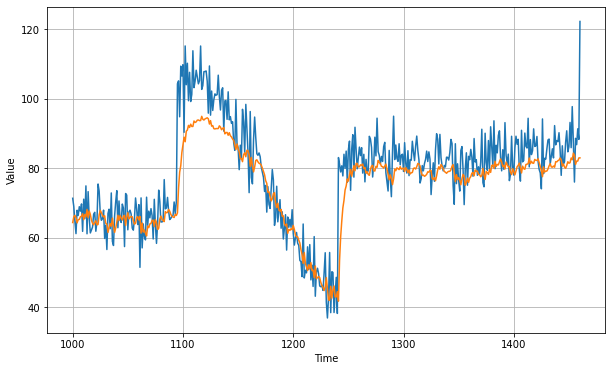

In [96]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [97]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.9196587

#  Forecasting with a CNN
## Preprocessing With 1D-Convolutional Layers

In [98]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

C:\Users\mjd\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
8/8 [==============================] - 5s 33ms/step - loss: 87.8346 - mae: 88.3341 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 31ms/step - loss: 87.1197 - mae: 87.6191 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 34ms/step - loss: 85.9241 - mae: 86.4234 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 32ms/step - loss: 84.3720 - mae: 84.8713 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 30ms/step - loss: 82.4702 - mae: 82.9696 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 34ms/step - loss: 80.2434 - mae: 80.7428 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 30ms/step - loss: 77.7459 - mae: 78.2453 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 29ms/step - loss: 75.0957 - mae: 75.5952 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 29ms/step - loss: 72.4508 - mae: 72.9504 - lr: 2.5

8/8 [==============================] - 0s 29ms/step - loss: 6.4469 - mae: 6.9313 - lr: 4.4668e-05
Epoch 75/100
8/8 [==============================] - 0s 28ms/step - loss: 6.8897 - mae: 7.3749 - lr: 5.0119e-05
Epoch 76/100
8/8 [==============================] - 0s 29ms/step - loss: 6.5211 - mae: 7.0051 - lr: 5.6234e-05
Epoch 77/100
8/8 [==============================] - 0s 33ms/step - loss: 7.7310 - mae: 8.2188 - lr: 6.3096e-05
Epoch 78/100
8/8 [==============================] - 0s 31ms/step - loss: 7.4164 - mae: 7.9035 - lr: 7.0795e-05
Epoch 79/100
8/8 [==============================] - 0s 32ms/step - loss: 7.2213 - mae: 7.7080 - lr: 7.9433e-05
Epoch 80/100
8/8 [==============================] - 0s 31ms/step - loss: 10.0946 - mae: 10.5855 - lr: 8.9125e-05
Epoch 81/100
8/8 [==============================] - 0s 30ms/step - loss: 16.1268 - mae: 16.6194 - lr: 1.0000e-04
Epoch 82/100
8/8 [==============================] - 0s 30ms/step - loss: 14.5050 - mae: 14.9987 - lr: 1.1220e-04
Epoch 83

(1e-08, 0.0001, 0.0, 30.0)

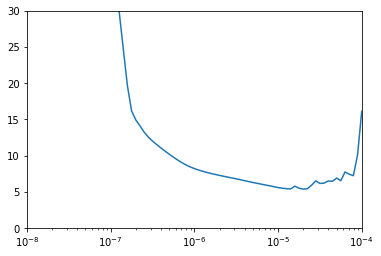

In [99]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [100]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 6s 234ms/step - loss: 56.9010 - mae: 57.4001 - val_loss: 28.7748 - val_mae: 29.2719
Epoch 2/500
8/8 [==============================] - 0s 48ms/step - loss: 26.1449 - mae: 26.6407 - val_loss: 38.9231 - val_mae: 39.4212
Epoch 3/500
8/8 [==============================] - 0s 47ms/step - loss: 17.3629 - mae: 17.8584 - val_loss: 30.1023 - val_mae: 30.6010
Epoch 4/500
8/8 [==============================] - 1s 133ms/step - loss: 12.0091 - mae: 12.4990 - val_loss: 24.5627 - val_mae: 25.0602
Epoch 5/500
8/8 [==============================] - 1s 67ms/step - loss: 9.9288 - mae: 10.4167 - val_loss: 18.8857 - val_mae: 19.3824
Epoch 6/500
8/8 [==============================] - 1s 69ms/step - loss: 8.8391 - mae: 9.3253 - val_loss: 16.0113 - val_mae: 16.5062
Epoch 7/500
8/8 [==============================] - 1s 75ms/step - loss: 8.0840 - mae: 8.5699 - val_loss: 12.5161 - val_mae: 13.0055
Epoch 8/500
8/8 [==============================] - 1s 70ms/step -

8/8 [==============================] - 0s 48ms/step - loss: 4.5189 - mae: 4.9947 - val_loss: 6.3861 - val_mae: 6.8702
Epoch 64/500
8/8 [==============================] - 0s 45ms/step - loss: 4.5203 - mae: 4.9967 - val_loss: 6.6530 - val_mae: 7.1364
Epoch 65/500
8/8 [==============================] - 1s 86ms/step - loss: 4.5504 - mae: 5.0273 - val_loss: 5.9738 - val_mae: 6.4559
Epoch 66/500
8/8 [==============================] - 0s 47ms/step - loss: 4.5613 - mae: 5.0384 - val_loss: 6.2280 - val_mae: 6.7108
Epoch 67/500
8/8 [==============================] - 0s 46ms/step - loss: 4.5187 - mae: 4.9957 - val_loss: 6.5304 - val_mae: 7.0145
Epoch 68/500
8/8 [==============================] - 0s 45ms/step - loss: 4.5129 - mae: 4.9895 - val_loss: 6.1017 - val_mae: 6.5840
Epoch 69/500
8/8 [==============================] - 0s 54ms/step - loss: 4.4907 - mae: 4.9673 - val_loss: 6.2073 - val_mae: 6.6910
Epoch 70/500
8/8 [==============================] - 0s 49ms/step - loss: 4.4814 - mae: 4.9571 - 

8/8 [==============================] - 0s 55ms/step - loss: 4.2980 - mae: 4.7725 - val_loss: 5.6921 - val_mae: 6.1743
Epoch 126/500
8/8 [==============================] - 0s 52ms/step - loss: 4.2996 - mae: 4.7740 - val_loss: 5.6605 - val_mae: 6.1420
Epoch 127/500
8/8 [==============================] - 0s 51ms/step - loss: 4.2927 - mae: 4.7675 - val_loss: 5.7762 - val_mae: 6.2588
Epoch 128/500
8/8 [==============================] - 0s 46ms/step - loss: 4.2910 - mae: 4.7658 - val_loss: 5.5400 - val_mae: 6.0194
Epoch 129/500
8/8 [==============================] - 0s 52ms/step - loss: 4.2914 - mae: 4.7656 - val_loss: 5.6031 - val_mae: 6.0846
Epoch 130/500
8/8 [==============================] - 0s 47ms/step - loss: 4.2931 - mae: 4.7671 - val_loss: 5.7311 - val_mae: 6.2135
Epoch 131/500
8/8 [==============================] - 0s 50ms/step - loss: 4.2940 - mae: 4.7685 - val_loss: 5.6295 - val_mae: 6.1114
Epoch 132/500
8/8 [==============================] - 0s 49ms/step - loss: 4.2885 - mae: 4.

8/8 [==============================] - 1s 54ms/step - loss: 4.1816 - mae: 4.6546 - val_loss: 5.5450 - val_mae: 6.0267
Epoch 188/500
8/8 [==============================] - 1s 55ms/step - loss: 4.1779 - mae: 4.6511 - val_loss: 5.3170 - val_mae: 5.7966
Epoch 189/500
8/8 [==============================] - 0s 52ms/step - loss: 4.1822 - mae: 4.6558 - val_loss: 5.4118 - val_mae: 5.8925
Epoch 190/500
8/8 [==============================] - 0s 44ms/step - loss: 4.1826 - mae: 4.6559 - val_loss: 5.3718 - val_mae: 5.8521
Epoch 191/500
8/8 [==============================] - 0s 45ms/step - loss: 4.1821 - mae: 4.6561 - val_loss: 5.6411 - val_mae: 6.1231
Epoch 192/500
8/8 [==============================] - 0s 49ms/step - loss: 4.1800 - mae: 4.6538 - val_loss: 5.5054 - val_mae: 5.9871
Epoch 193/500
8/8 [==============================] - 0s 53ms/step - loss: 4.1767 - mae: 4.6499 - val_loss: 5.6972 - val_mae: 6.1788
Epoch 194/500
8/8 [==============================] - 0s 50ms/step - loss: 4.1734 - mae: 4.

8/8 [==============================] - 0s 55ms/step - loss: 4.1206 - mae: 4.5922 - val_loss: 5.2875 - val_mae: 5.7681
Epoch 250/500
8/8 [==============================] - 0s 55ms/step - loss: 4.1206 - mae: 4.5930 - val_loss: 5.3457 - val_mae: 5.8264
Epoch 251/500
8/8 [==============================] - 0s 45ms/step - loss: 4.1196 - mae: 4.5918 - val_loss: 5.2536 - val_mae: 5.7331
Epoch 252/500
8/8 [==============================] - 1s 74ms/step - loss: 4.1179 - mae: 4.5903 - val_loss: 5.1686 - val_mae: 5.6477
Epoch 253/500
8/8 [==============================] - 1s 59ms/step - loss: 4.1136 - mae: 4.5853 - val_loss: 5.1595 - val_mae: 5.6380
Epoch 254/500
8/8 [==============================] - 0s 44ms/step - loss: 4.1226 - mae: 4.5953 - val_loss: 5.1756 - val_mae: 5.6540
Epoch 255/500
8/8 [==============================] - 0s 52ms/step - loss: 4.1132 - mae: 4.5852 - val_loss: 5.3376 - val_mae: 5.8187
Epoch 256/500
8/8 [==============================] - 0s 43ms/step - loss: 4.1096 - mae: 4.

8/8 [==============================] - 0s 51ms/step - loss: 4.0843 - mae: 4.5560 - val_loss: 5.3266 - val_mae: 5.8076
Epoch 312/500
8/8 [==============================] - 0s 44ms/step - loss: 4.0889 - mae: 4.5604 - val_loss: 5.0728 - val_mae: 5.5519
Epoch 313/500
8/8 [==============================] - 0s 43ms/step - loss: 4.1019 - mae: 4.5743 - val_loss: 5.0701 - val_mae: 5.5475
Epoch 314/500
8/8 [==============================] - 0s 52ms/step - loss: 4.0933 - mae: 4.5650 - val_loss: 5.1199 - val_mae: 5.5988
Epoch 315/500
8/8 [==============================] - 0s 47ms/step - loss: 4.0764 - mae: 4.5475 - val_loss: 5.3246 - val_mae: 5.8055
Epoch 316/500
8/8 [==============================] - 0s 48ms/step - loss: 4.0818 - mae: 4.5535 - val_loss: 5.3323 - val_mae: 5.8133
Epoch 317/500
8/8 [==============================] - 0s 44ms/step - loss: 4.0877 - mae: 4.5600 - val_loss: 5.2706 - val_mae: 5.7511
Epoch 318/500
8/8 [==============================] - 0s 49ms/step - loss: 4.0710 - mae: 4.

8/8 [==============================] - ETA: 0s - loss: 4.0532 - mae: 4.524 - 1s 54ms/step - loss: 4.0490 - mae: 4.5200 - val_loss: 5.0125 - val_mae: 5.4914
Epoch 374/500
8/8 [==============================] - 0s 50ms/step - loss: 4.0529 - mae: 4.5234 - val_loss: 5.1367 - val_mae: 5.6164
Epoch 375/500
8/8 [==============================] - 0s 53ms/step - loss: 4.0751 - mae: 4.5466 - val_loss: 5.5693 - val_mae: 6.0492
Epoch 376/500
8/8 [==============================] - 1s 54ms/step - loss: 4.0958 - mae: 4.5683 - val_loss: 5.3615 - val_mae: 5.8424
Epoch 377/500
8/8 [==============================] - 0s 51ms/step - loss: 4.0637 - mae: 4.5350 - val_loss: 5.2847 - val_mae: 5.7650
Epoch 378/500
8/8 [==============================] - 1s 53ms/step - loss: 4.0520 - mae: 4.5229 - val_loss: 5.2584 - val_mae: 5.7390
Epoch 379/500
8/8 [==============================] - 1s 57ms/step - loss: 4.0671 - mae: 4.5387 - val_loss: 5.3630 - val_mae: 5.8442
Epoch 380/500
8/8 [==============================] -

In [101]:
model = keras.models.load_model("my_checkpoint.h5")

In [102]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

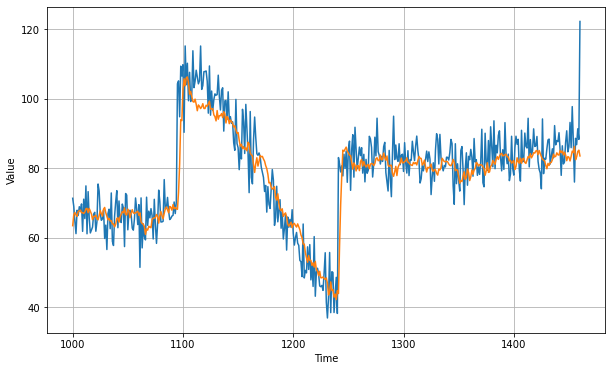

In [103]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [104]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.112425

## Fully Convolutional Forecasting

In [105]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

C:\Users\mjd\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
8/8 [==============================] - 2s 57ms/step - loss: 42.2341 - mae: 42.7330 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 1s 62ms/step - loss: 41.8293 - mae: 42.3284 - lr: 1.0798e-04
Epoch 3/100
8/8 [==============================] - 1s 54ms/step - loss: 41.4367 - mae: 41.9357 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 1s 54ms/step - loss: 41.0108 - mae: 41.5098 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 1s 52ms/step - loss: 40.4787 - mae: 40.9776 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 1s 63ms/step - loss: 39.7341 - mae: 40.2328 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 1s 54ms/step - loss: 38.5883 - mae: 39.0871 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 1s 51ms/step - loss: 36.6836 - mae: 37.1823 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 1s 52ms/step - loss: 33.3644 - mae: 33.8629 - lr: 1.8

8/8 [==============================] - 1s 68ms/step - loss: 11.0235 - mae: 11.5136 - lr: 0.0293
Epoch 76/100
8/8 [==============================] - 1s 63ms/step - loss: 9.3685 - mae: 9.8545 - lr: 0.0316
Epoch 77/100
8/8 [==============================] - 1s 57ms/step - loss: 5.7988 - mae: 6.2807 - lr: 0.0341
Epoch 78/100
8/8 [==============================] - 1s 66ms/step - loss: 5.2714 - mae: 5.7506 - lr: 0.0369
Epoch 79/100
8/8 [==============================] - 1s 66ms/step - loss: 5.8791 - mae: 6.3608 - lr: 0.0398
Epoch 80/100
8/8 [==============================] - 1s 54ms/step - loss: 6.1385 - mae: 6.6199 - lr: 0.04306.3432 - mae: 6.82
Epoch 81/100
8/8 [==============================] - 1s 55ms/step - loss: 6.3044 - mae: 6.7870 - lr: 0.0464
Epoch 82/100
8/8 [==============================] - 1s 60ms/step - loss: 7.0051 - mae: 7.4903 - lr: 0.0501
Epoch 83/100
8/8 [==============================] - 1s 63ms/step - loss: 6.0343 - mae: 6.5147 - lr: 0.0541
Epoch 84/100
8/8 [============

(0.0001, 0.1, 0.0, 30.0)

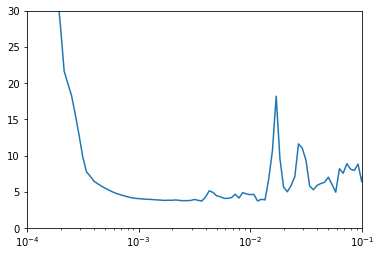

In [106]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [107]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 4s 265ms/step - loss: 40.1883 - mae: 40.6871 - val_loss: 72.9189 - val_mae: 73.4189
Epoch 2/500
8/8 [==============================] - 1s 112ms/step - loss: 38.1153 - mae: 38.6140 - val_loss: 67.9778 - val_mae: 68.4778
Epoch 3/500
8/8 [==============================] - 1s 121ms/step - loss: 35.1358 - mae: 35.6344 - val_loss: 60.8665 - val_mae: 61.3665
Epoch 4/500
8/8 [==============================] - 1s 107ms/step - loss: 30.8281 - mae: 31.3263 - val_loss: 50.2195 - val_mae: 50.7191
Epoch 5/500
8/8 [==============================] - 1s 116ms/step - loss: 24.9596 - mae: 25.4564 - val_loss: 36.6520 - val_mae: 37.1480
Epoch 6/500
8/8 [==============================] - 1s 123ms/step - loss: 20.1383 - mae: 20.6330 - val_loss: 32.0186 - val_mae: 32.5158
Epoch 7/500
8/8 [==============================] - 1s 108ms/step - loss: 18.8909 - mae: 19.3859 - val_loss: 30.0781 - val_mae: 30.5755
Epoch 8/500
8/8 [==============================] - 1s 1

Epoch 63/500
8/8 [==============================] - 1s 93ms/step - loss: 3.7899 - mae: 4.2597 - val_loss: 4.2352 - val_mae: 4.7095
Epoch 64/500
8/8 [==============================] - 1s 79ms/step - loss: 3.7833 - mae: 4.2531 - val_loss: 4.2393 - val_mae: 4.7140
Epoch 65/500
8/8 [==============================] - 1s 78ms/step - loss: 3.7779 - mae: 4.2477 - val_loss: 4.2489 - val_mae: 4.7238
Epoch 66/500
8/8 [==============================] - 1s 89ms/step - loss: 3.7726 - mae: 4.2422 - val_loss: 4.2992 - val_mae: 4.7764
Epoch 67/500
8/8 [==============================] - 1s 80ms/step - loss: 3.7733 - mae: 4.2429 - val_loss: 4.2516 - val_mae: 4.7266
Epoch 68/500
8/8 [==============================] - 1s 117ms/step - loss: 3.7611 - mae: 4.2304 - val_loss: 4.2118 - val_mae: 4.6860
Epoch 69/500
8/8 [==============================] - 1s 84ms/step - loss: 3.7528 - mae: 4.2217 - val_loss: 4.2967 - val_mae: 4.7739
Epoch 70/500
8/8 [==============================] - 1s 104ms/step - loss: 3.7506 -

8/8 [==============================] - 1s 85ms/step - loss: 3.4947 - mae: 3.9572 - val_loss: 4.1969 - val_mae: 4.6731
Epoch 126/500
8/8 [==============================] - 1s 111ms/step - loss: 3.4949 - mae: 3.9578 - val_loss: 4.1960 - val_mae: 4.6722
Epoch 127/500
8/8 [==============================] - 1s 80ms/step - loss: 3.4894 - mae: 3.9512 - val_loss: 4.2887 - val_mae: 4.7649
Epoch 128/500
8/8 [==============================] - 1s 84ms/step - loss: 3.4870 - mae: 3.9482 - val_loss: 4.2085 - val_mae: 4.6845
Epoch 129/500
8/8 [==============================] - 1s 98ms/step - loss: 3.4804 - mae: 3.9412 - val_loss: 4.1852 - val_mae: 4.6607
Epoch 130/500
8/8 [==============================] - 1s 86ms/step - loss: 3.4791 - mae: 3.9399 - val_loss: 4.2573 - val_mae: 4.7335
Epoch 131/500
8/8 [==============================] - 1s 86ms/step - loss: 3.4757 - mae: 3.9365 - val_loss: 4.2672 - val_mae: 4.7430
Epoch 132/500
8/8 [==============================] - 1s 95ms/step - loss: 3.4726 - mae: 3

In [108]:
model = keras.models.load_model("my_checkpoint.h5")

In [109]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

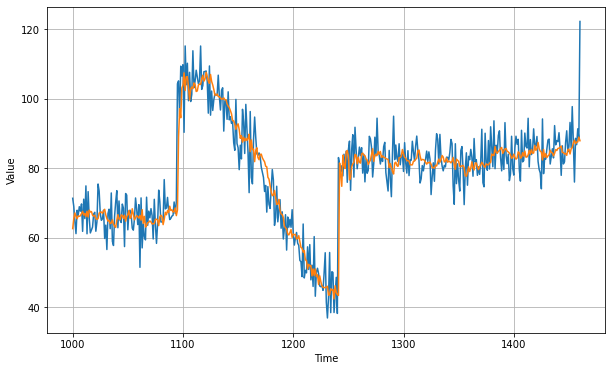

In [110]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [111]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.5239267